#### Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()


# The goal of this notebook is to help you get an understanding of how Deep Learning models work under the hood. 

In this notebook we will:
- Introduce the problem we'll solve with ML.
- define a forward pass through our model
- define a cost function
- create a backward pass to update the model



## Introducing the problem

You are working for an insurance company who wants to predict the total payment for all the claims in thousands of Swedish Kronor for geographical zones in Sweden. We will work with only one feature, the number of claims received, and will use that information to train our model and make predictions.

In [20]:
# import packages we need :)
from typing import Tuple, List
import requests
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [21]:
# You can skip understanding the following code. It's only here to get some data to work with.
def build_auto_insurance_dataset() -> Tuple[List[float], List[float]]:
    url='https://www.math.muni.cz/~kolacek/docs/frvs/M7222/data/AutoInsurSweden.txt'
    raw_dataset = requests.get(url)
    features, labels = [], []
    index_at_which_features_and_labels_start = 11

    raw_data = raw_dataset.text.split("\n")[index_at_which_features_and_labels_start:-1]
    for feature_and_label in raw_data:
        feature_and_label = feature_and_label.split("\t")
        features.append([float(feature_and_label[0].replace(",", "."))])
        labels.append(float(feature_and_label[1].replace(",", ".")))
    return jnp.array(features), jnp.array(labels).reshape(-1, 1)


# some plotting utils to plot our beautiful graphs

class PlottingUtils:
    @staticmethod
    def plot_results(features: List[float], labels: List[float], predictions: List[float]):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(features, labels, 'bo', label='Real values')
        ax.plot(features, predictions, 'ro', label='Predicted values')
        ax.plot(features.reshape(-1), predictions.reshape(-1), label='Real values')
        ax.legend(["Actual", "Predicted"])
        ax.set_ylabel("Claims in thousands of Swedish kronor")
        ax.set_xlabel("Number of claims")
        return fig, ax


In [22]:
# features is equal to the total number of claims for a given year
# labels is the total payment for all claims in thousands of Swedish kronor
features, labels = build_auto_insurance_dataset()


## Forward pass

We'll be building a very simple network (just a linear regression, yay). The model is defined as f = w * x + b, where y is the value we want to predict, w and b are the parameters we'll optimize and x is the input feature.


Our features has shape: (63, 1)


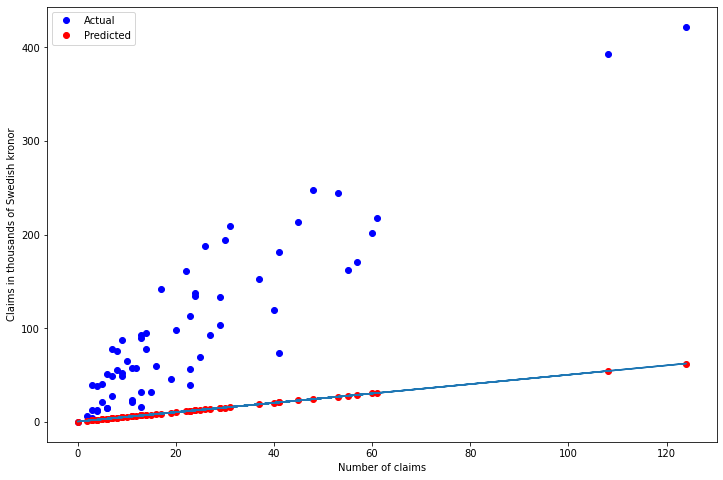

In [23]:
# Introduction to linear regression: f = w * x + b also know as the forward pass.
def forward_pass(feature: jnp.ndarray, weight: jnp.ndarray, bias: jnp.ndarray) -> jnp.ndarray:
    return weight * feature + bias


# features is a MxN matrix, where M is the number of examples and N is the number of features
# In our case, N is 1, because we have only one feature
# M is the number of examples, which in our case is 63
# As a result our output is a 63x1 matrix
print(f"Our features has shape: {features.shape}")

# We know our model is a Linear Regression model, meaning we have F_w_b(x) = w * x + b where w, b are the model parameters and are a scalar value.
# and x is the model input, which is also a scalar value.
weight = jnp.array([0.5])
bias = jnp.array([0.5]) 
predictions = jnp.array([])
for feature in features:
    prediction = forward_pass(feature=feature, weight=weight, bias=bias)
    predictions = jnp.append(predictions, prediction)


# Lets plot the results
_ = PlottingUtils.plot_results(features, labels, predictions)

That doesn't look too good... But "doesn't look good" is still a bit vague, don't you think?! Let's try to make it a bit more unambiguous and for that, we need a cost function. 
A cost function is a summation over the loss function for all examples. Arrgh why does that sound so complicated. Can't you be a bit more explicit? Sure :)

Lets first define the loss function: 
$$
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2
$$

The loss function determines how far "off" you are from the true value. The larger the loss is the further away you are from your target.
Now the $y^{true}_i$ is historical data that has already been collected (in our case the claims in thousands of Swedish Kronor)
Our prediction is what we need to compute, which we did during the forward pass. so, we can substitute that in our little formula below.


$$
\begin{align}
forward pass = y^{pred}_i \\
y^{pred}_i = f_{w,b}(x_i)  \\
f_{w,b}(x_i) = w * x_i + b \\
\end{align}
$$
$$
\begin{align}
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2 \\
L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2} * (w * x_i + b - y^{true}_{i})^2 
\end{align}
$$

Alright. So the loss function is defined, but this is only for one feature, label pair (or more simple stated: one training example).
The next part has to do with the cost function often denoted as $J(w, b)$. What does this mean? For a given weight $w$ and bias $b$, calculate the loss function over all training examples.

$$

\frac{1}{m}\sum^{m - 1}_{i=0} * L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2m}\sum^{m - 1}_{i=0}(f_{w,b}(x_{i}) - y_i)^2
$$

notice how we moved the constant out of the equation. In addition that we substitute the quadratic term in the final part of the equation for the $L$.

Pfoeee.... that are quite some lines of mathematical notation. But for now, using the famous words of Andrew Ng, don't worry about it. Lets see some actual code.


In [24]:
# remember that the loss is the difference between the predicted value and the actual value
# and is only for a single example
def calculate_loss(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return 1 / 2 * (predictions - labels) ** 2

# calculate the loss for all examples
def calculate_cost(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(calculate_loss(predictions, labels))

total_cost = calculate_cost(predictions=predictions, labels=jnp.array(labels))

print(f"The total cost is: {total_cost}")

The total cost is: 7537.8271484375


In [25]:
# Gradient descent
# Taking the derivate of the cost function with respect to the weight and bias.
def compute_gradient(features, weight, bias, labels):
    predictions = forward_pass(features, weight, bias)

    weight_derivative = jnp.mean(((predictions - labels) * features))  
    bias_derivative = jnp.mean((predictions - labels) * 1)
    return weight_derivative, bias_derivative

# update weights and bias using the gradient descent algorithm.
def update_weights(features, weight, bias, labels, learning_rate):
    weight_derivative, bias_derivative = compute_gradient(features, weight, bias, labels)
    weight = weight - learning_rate * weight_derivative
    bias = bias - learning_rate * bias_derivative
    return weight, bias


## Full training loop pseudo code
1. initialize weight and bias
2. for i in ...epochs:
    - 2a. forwardpass
    - 2b. calculate cost
    - 2c update weights


In [26]:

# 1. init weights
weight = 0
bias = 0

# 2. for i in ...epochs
n_epochs = 50
learning_rate = 0.0001
for i in range(n_epochs):

    # 2a forward pass
    predictions = forward_pass(features, weight, bias)
    # 2b cost calculation
    cost = calculate_cost(predictions, labels)
    
    # 2c update weights and bias
    weight, bias = update_weights(features, weight, bias, labels, learning_rate)
    if i % 5 == 0:
        print(f"Epoch: {i} Cost: {cost}")

Epoch: 0 Cost: 8572.900390625
Epoch: 5 Cost: 3279.61328125
Epoch: 10 Cost: 1556.776611328125
Epoch: 15 Cost: 996.0113525390625
Epoch: 20 Cost: 813.46533203125
Epoch: 25 Cost: 754.0178833007812
Epoch: 30 Cost: 734.6356811523438
Epoch: 35 Cost: 728.2933349609375
Epoch: 40 Cost: 726.1950073242188
Epoch: 45 Cost: 725.4779663085938


Lets see if we are doing any better than before

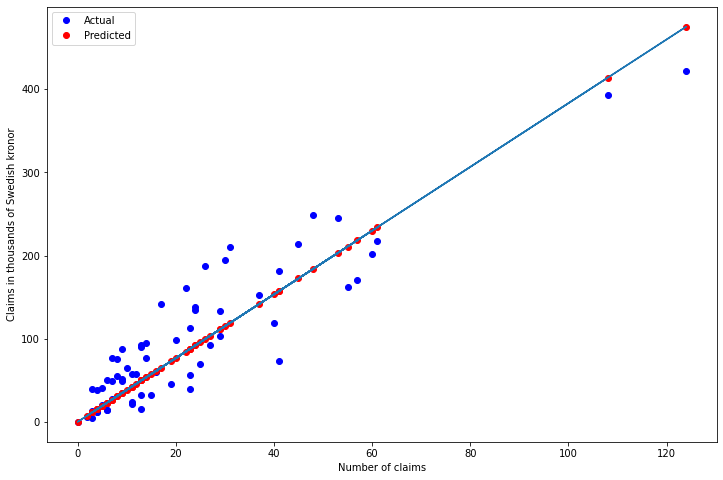

In [27]:
fig, ax = PlottingUtils.plot_results(
    features,
    labels,
    forward_pass(features, weight, bias)
)

That looks pretty good! Now we can use our model to make some predictions

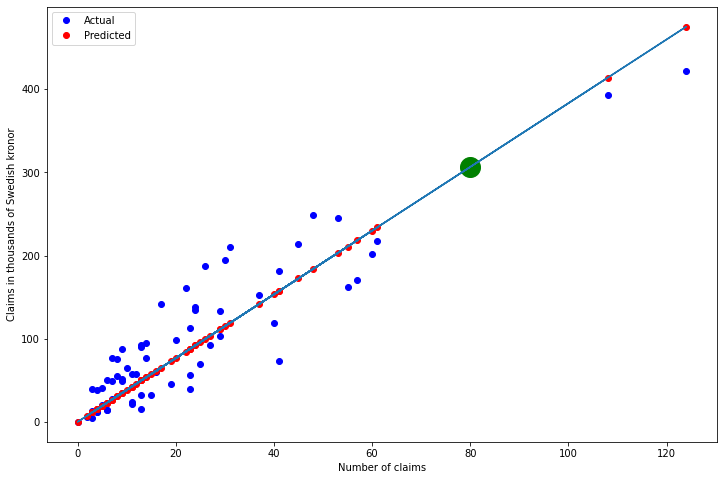

In [28]:
new_number_of_claims = jnp.array([80])
prediction = forward_pass(new_number_of_claims, weight, bias)
ax.scatter(new_number_of_claims, prediction, s=400, c='g')

fig

Pretty cool. We build a model, got a better understanding of a loss/cost function (remember what the difference is?), implemented gradient descent and finally made a prediction. If you made it this far, I congratulate you! 

## Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()
